In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = r"/content/Node B 20m first test.csv"
df = pd.read_csv(file_path)

print(df.columns)
print(df.head())

date_column = 'Timestamp'
value_column = 'Data'

df[date_column] = pd.to_datetime(df[date_column], format='%H:%M:%S.%f')
df.set_index(date_column, inplace=True)

df = df[(df[value_column] >= -600) & (df[value_column] <= 600)]

test_intervals = {
    'calibration': ('12:09:16', '12:20:15'),
}


test_intervals = {k: (pd.to_datetime(v[0]).time(), pd.to_datetime(v[1]).time() if v[1] else None) for k, v in test_intervals.items()}

for test, (start_time, end_time) in test_intervals.items():
    if end_time:
        test_df = df.between_time(start_time, end_time)
    else:
        test_df = df[df.index.time >= start_time]

    plt.figure(figsize=(10, 6))
    plt.plot(test_df[value_column])
    plt.title(f'Time Series Plot for {test.replace("_", " ").title()}')
    plt.xlabel('Timestamp')
    plt.ylabel('ADC Value')
    plt.ylim(-100, 100)
    plt.grid(True)
    plt.show()

    csv_filename = f"{test}.csv"
    test_df.to_csv(csv_filename)
    print(f"Saved {csv_filename}")


Index(['Timestamp', 'Data'], dtype='object')
                 Timestamp  Data
0  1900-01-01 12:09:16.044    -4
1  1900-01-01 12:09:16.048     0
2  1900-01-01 12:09:16.052    -5
3  1900-01-01 12:09:16.056    -5
4  1900-01-01 12:09:16.060    -7


ValueError: time data "1900-01-01 12:09:16.044" doesn't match format "%H:%M:%S.%f", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Labeled data saved to /content/Labelled Data/random_tests.csv


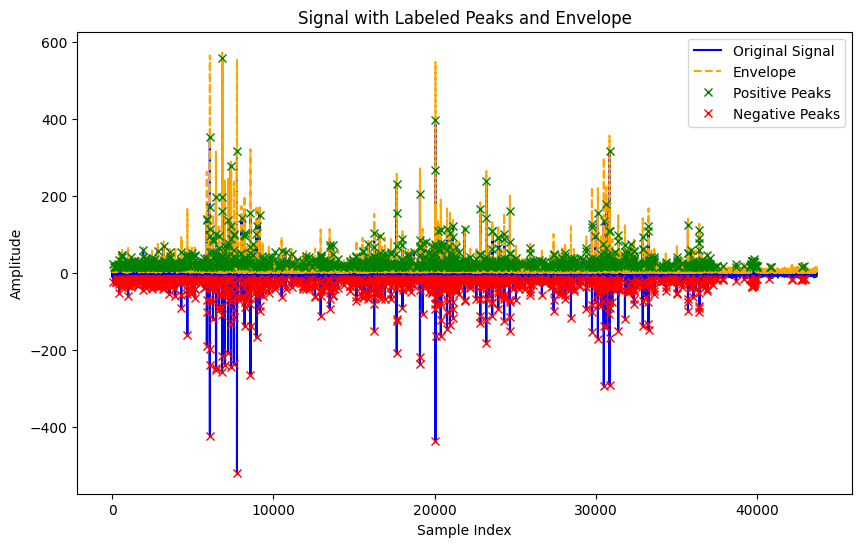

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, hilbert
import matplotlib.pyplot as plt

# Input and output file paths
input_file_path = r"/content/random_tests.csv"
output_file_path = r"/content/Labelled Data/random_tests.csv"  # Update this with your desired output path

df = pd.read_csv(input_file_path)

signal = df['Data'].values

positive_peaks, _ = find_peaks(signal, height=15, distance=2)
negative_peaks, _ = find_peaks(-signal, height=15, distance=2)

all_peaks = np.concatenate((positive_peaks, negative_peaks))
all_peaks.sort()

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

labels = np.zeros_like(signal)

amplitude_threshold = 15

labels[signal >= amplitude_threshold] = 1
labels[signal <= -amplitude_threshold] = 1

df['Label'] = labels

# Save the labeled data to a new CSV file
df.to_csv(output_file_path, index=False)
print(f"Labeled data saved to {output_file_path}")

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(signal, label='Original Signal', color='blue')
ax1.plot(amplitude_envelope, label='Envelope', linestyle='--', color='orange')
ax1.plot(positive_peaks, signal[positive_peaks], "x", label='Positive Peaks', color='green')
ax1.plot(negative_peaks, signal[negative_peaks], "x", label='Negative Peaks', color='red')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Amplitude')
ax1.legend(loc='upper right')

plt.title('Signal with Labeled Peaks and Envelope')
plt.show()


In [ ]:
import pandas as pd
import os

csv_files = [
    r"/content/Labelled Data/center_1.csv",
    r"/content/Labelled Data/center_2.csv",
    r"/content/Labelled Data/triangular_1.csv",
    r"/content/Labelled Data/triangular_2.csv",
    r"/content/Labelled Data/random_tests.csv"
]

output_file_path = r"/content/Labelled Data/output_final.csv"

dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv(output_file_path, index=False)
print(f"Combined data saved to {output_file_path}")


Combined data saved to /content/Labelled Data/output_final.csv


In [ ]:
##Code to determine the length of the sequences we are feeding the model per inference
import pandas as pd

input_file_path = r"/content/Labelled Data/output_final.csv"

df = pd.read_csv(input_file_path)

labels = df['Label'].values

sequence_lengths = []
current_length = 0

for label in labels:
    if label == 1:
        current_length += 1
    else:
        if current_length > 0:
            sequence_lengths.append(current_length)
            current_length = 0
if current_length > 0:
    sequence_lengths.append(current_length)

if sequence_lengths:
    average_length = sum(sequence_lengths) / len(sequence_lengths)
else:
    average_length = 0

print(f"Average length of consecutive 1s: {average_length}")


Average length of consecutive 1s: 2.4825986078886313


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Reshape, LSTM, Dropout, Dense
data = pd.read_csv('/content/output_final (1).csv')

def create_sequences(data, sequence_length=4):
    X, y = [], []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        X.append(data.iloc[i:i + sequence_length]['Data'].values.reshape(-1, 1))
        y.append(data.iloc[i + sequence_length - 1]['Label'])
    return np.array(X), np.array(y)

X, y = create_sequences(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

## Testing Model 1
model = Sequential([
    InputLayer(input_shape=(4, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(200, return_sequences=False, unroll=True),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for two-class multi-class classification
])


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001)

history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

evaluation = model.evaluate(X_test, y_test)

print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

model.save('cnn_lstm_model.h5')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8896 - loss: 0.3956 - val_accuracy: 0.9704 - val_loss: 0.0669
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9650 - loss: 0.0778 - val_accuracy: 0.9825 - val_loss: 0.0452
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9746 - loss: 0.0595 - val_accuracy: 0.9833 - val_loss: 0.0416
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9761 - loss: 0.0526 - val_accuracy: 0.9860 - val_loss: 0.0362
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0479 - val_accuracy: 0.9895 - val_loss: 0.0323
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9809 - loss: 0.0441 - val_accuracy: 0.9873 - val_loss: 0.0321
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.0437 - val_accuracy: 0.9890 - val_loss: 0.0290
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.0371 - val_accuracy: 0.9876 - val_loss: 0.0305
Ep

Test Loss: 0.02697775512933731, Test Accuracy: 0.9890062808990479


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


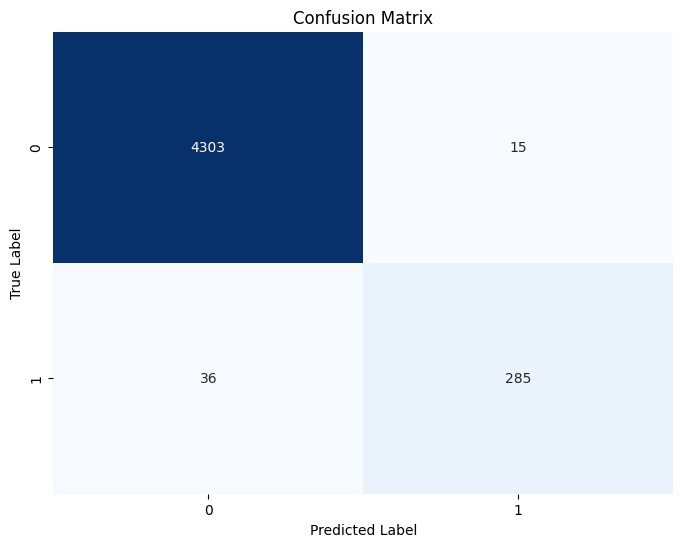

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4318
           1       0.95      0.89      0.92       321

    accuracy                           0.99      4639
   macro avg       0.97      0.94      0.96      4639
weighted avg       0.99      0.99      0.99      4639



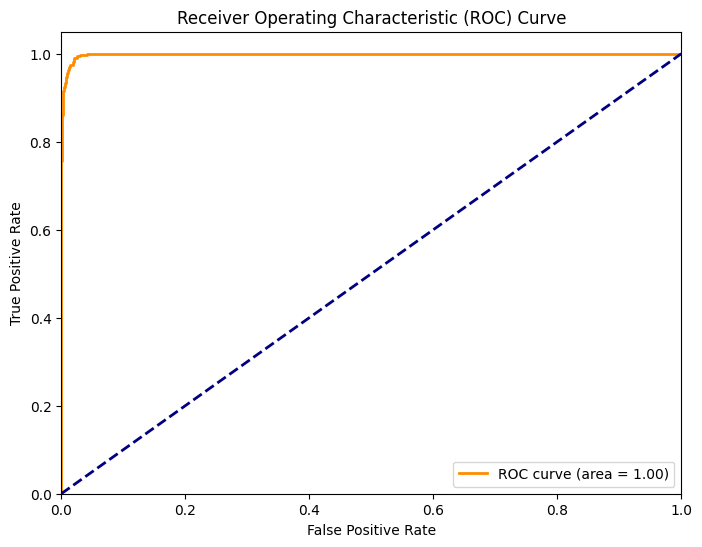

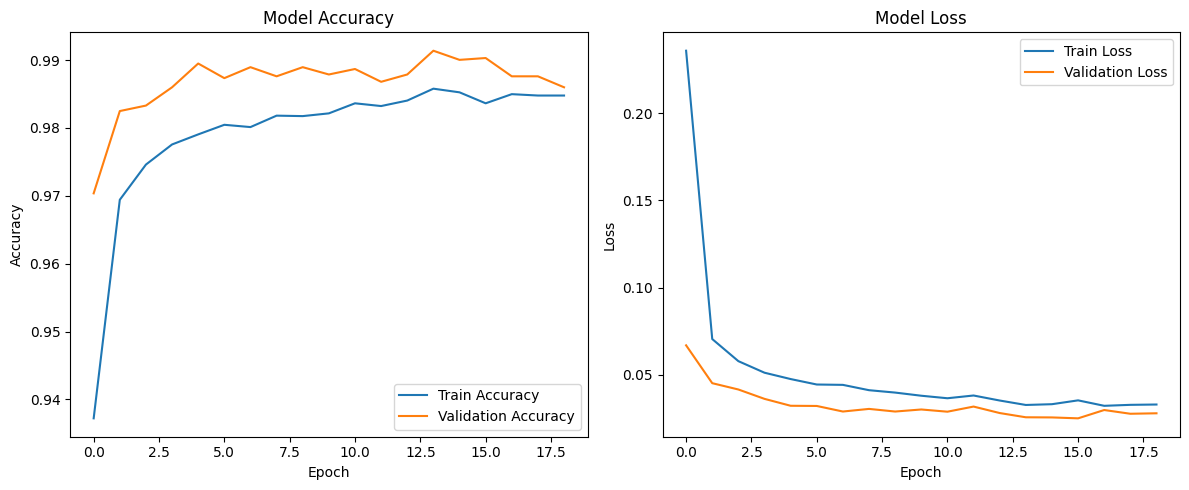

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('cnn_lstm_model.h5')

y_pred_prob = model.predict(X_test)
if y_pred_prob.shape[1] == 1:
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
else:
    y_pred = np.argmax(y_pred_prob, axis=1)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_labels, y_pred))
if y_pred_prob.shape[1] == 1:
    fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_prob)
else:
    fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_prob[:, 1])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def create_sequences(data, sequence_length=4):
    X, y = [], []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        X.append(data.iloc[i:i + sequence_length]['Data'].values.reshape(-1, 1))
        y.append(data.iloc[i + sequence_length - 1]['Label'])
    return np.array(X), np.array(y)

X, y = create_sequences(data)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

model = Sequential([
    InputLayer(shape=(4, 1, 1)),
    Conv2D(filters=64, kernel_size=(3, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Reshape((1, 64)),
    LSTM(200, return_sequences=False, unroll=True),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

optimizer = Adam(learning_rate=0.00001)

history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2) #callbacks=[early_stopping])

evaluation = model.evaluate(X_test, y_test)

print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

model.save('cnn2d_lstm_model_2D.h5')


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8735 - loss: 0.3868 - val_accuracy: 0.9725 - val_loss: 0.0651
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9700 - loss: 0.0687 - val_accuracy: 0.9854 - val_loss: 0.0403
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9754 - loss: 0.0558 - val_accuracy: 0.9860 - val_loss: 0.0366
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9785 - loss: 0.0499 - val_accuracy: 0.9887 - val_loss: 0.0327
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.0440 - val_accuracy: 0.9890 - val_loss: 0.0297
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - loss: 0.0382 - val_accuracy: 0.9868 - val_loss: 0.0327
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9837 - loss: 0.0367 - val_accuracy: 0.9887 - val_loss: 0.0289
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0371 - val_accuracy: 0.9890 - 

Test Loss: 0.022462382912635803, Test Accuracy: 0.9911618828773499


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


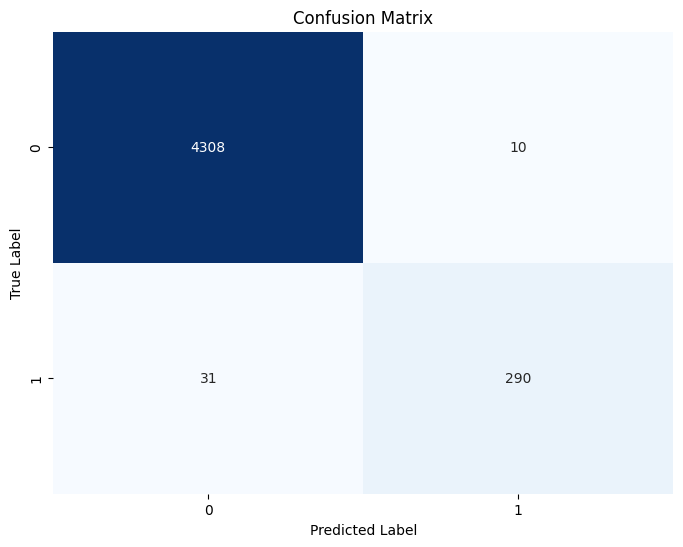

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4318
           1       0.97      0.90      0.93       321

    accuracy                           0.99      4639
   macro avg       0.98      0.95      0.96      4639
weighted avg       0.99      0.99      0.99      4639



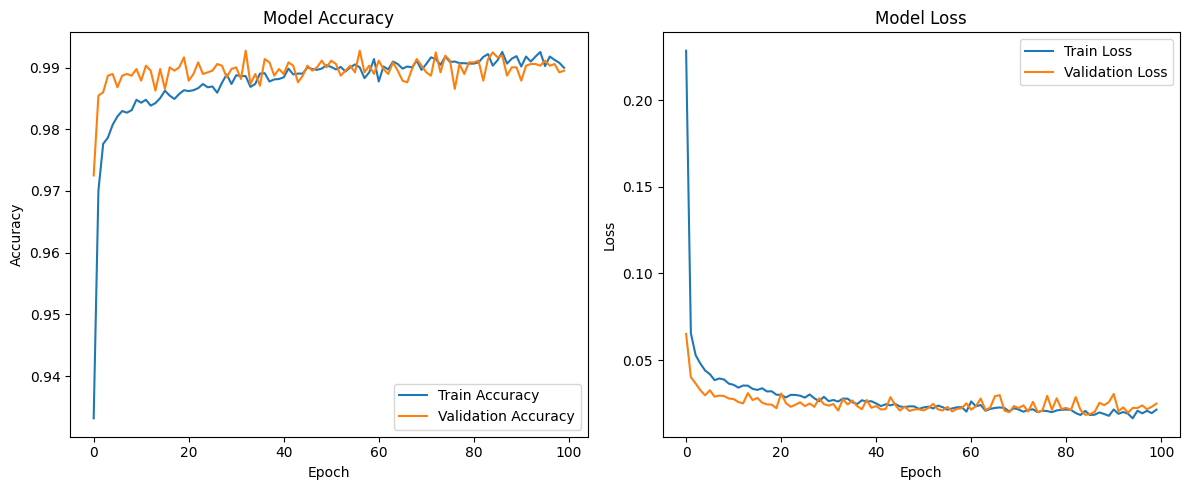

In [ ]:
model = load_model('cnn2d_lstm_model_2D.h5')
y_pred_prob = model.predict(X_test)
is_binary_classification = y_pred_prob.shape[1] == 1
if is_binary_classification:
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
else:
    y_pred = np.argmax(y_pred_prob, axis=1)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test_labels, y_pred))
if is_binary_classification:
    fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
if 'history' in locals() or 'history' in globals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

input_file_path = r"/content/Labelled Data/output_final.csv"
df = pd.read_csv(input_file_path)

signal_data = df['Data'].values
labels = df['Label'].values

sequence_length = 4

X = []
y = []

for i in range(len(signal_data) - sequence_length + 1):
    X.append(signal_data[i:i + sequence_length])
    y.append(labels[i:i + sequence_length])

X = np.array(X)
y = np.array(y)

# Use a subset of X as the representative dataset
def representative_dataset_gen():
    for value in X[:100]:  # Take the first 100 sequences for simplicity
        yield [np.array(value, dtype=np.float32).reshape(1, sequence_length, 1)]

model=tf.keras.models.load_model('cnn2d_lstm_model_2D.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen

# Enable experimental features
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Disable the experimental lowering of tensor list operations
converter._experimental_lower_tensor_list_ops = False

# Set the input and output tensors to integer types
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
try:
    tflite_model = converter.convert()
    # Save the TFLite model
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Model conversion successful!")
except Exception as e:
    print(f"Model conversion failed: {e}")


Saved artifact at '/tmp/tmp90d6jkw0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 1, 1), dtype=tf.float32, name='input_layer_22')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135162846827216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162846826336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162844619248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162844613968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162647184832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162647188176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162647183776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135166371701056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135162646138192: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model conversion failed: tensorflow/lite/kernels/conv.cc:346 input->dims->size != 4 (3 !

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

def add_noise(data, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, data.shape)
    return data + noise

def create_sequences(data, sequence_length=3):
    X, y = [], []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        X.append(data.iloc[i:i + sequence_length]['Data'].values.reshape(-1, 1))
        y.append(data.iloc[i + sequence_length - 1]['Label'])
    return np.array(X), np.array(y)

data = pd.read_csv('/content/output_final (1).csv')

data['Data'] = add_noise(data['Data'], noise_factor=0.01)

X, y = create_sequences(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

model_lstm = Sequential([
    InputLayer(input_shape=(3, 1)),
    LSTM(50, return_sequences=True, unroll=True),
    LSTM(25, return_sequences=False, unroll=True),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2, callbacks=[early_stopping_lstm])

evaluation_lstm = model_lstm.evaluate(X_test, y_test)

print(f"LSTM-only Model Test Loss: {evaluation_lstm[0]}, Test Accuracy: {evaluation_lstm[1]}")

model_lstm.save('lstm_only_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8474 - loss: 0.5446 - val_accuracy: 0.9343 - val_loss: 0.1678
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9432 - loss: 0.1468 - val_accuracy: 0.9679 - val_loss: 0.0766
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9642 - loss: 0.0858 - val_accuracy: 0.9842 - val_loss: 0.0420
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9853 - loss: 0.0435 - val_accuracy: 0.9947 - val_loss: 0.0176
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0229 - val_accuracy: 0.9929 - val_loss: 0.0144
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0169 - val_accuracy: 0.9956 - val_loss: 0.0103
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0123 - val_accuracy: 0.9984 - val_loss: 0.0069
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0118 - val_accuracy: 0.9986 - val_los

LSTM-only Model Test Loss: 0.001884676981717348, Test Accuracy: 0.999353289604187


194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


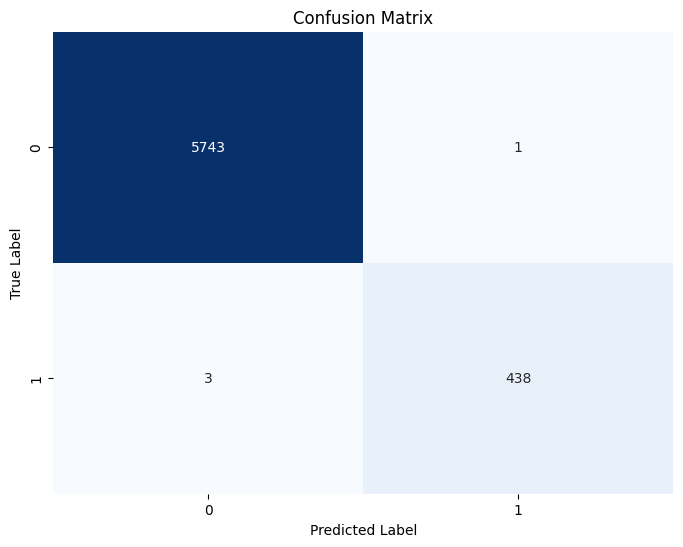

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5744
           1       1.00      0.99      1.00       441

    accuracy                           1.00      6185
   macro avg       1.00      1.00      1.00      6185
weighted avg       1.00      1.00      1.00      6185



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('lstm_only_model.h5')
y_pred_prob = model.predict(X_test)
is_binary_classification = y_pred_prob.shape[1] == 1
if is_binary_classification:
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
else:
    y_pred = np.argmax(y_pred_prob, axis=1)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test_labels, y_pred))
if is_binary_classification:
    fpr, tpr, thresholds = roc_curve(y_test_labels, y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
if 'history' in locals() or 'history' in globals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Load your Keras model
model = tf.keras.models.load_model('/content/lstm_only_model.h5')

def representative_dataset_generator():
    for _ in range(100):
        data = np.random.uniform(-1000, 1000, size=(1, 3, 1))
        yield [data.astype(np.float32)]
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset_generator

converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quantized_model = converter.convert()

with open('model_quantized_int8.tflite', 'wb') as f:
    f.write(tflite_quantized_model)

print("Model has been successfully converted to TFLite with int8 quantization.")


Saved artifact at '/tmp/tmpsci1bcgx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140635104534496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104541712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104537488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104566736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104568672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104568320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104681600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104685296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104792592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635104794880: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model has been successfully converted to TFLite with int8 quantization.


In [ ]:
!xxd -i model_quantized_int8.tflite > model_data.h

1076/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


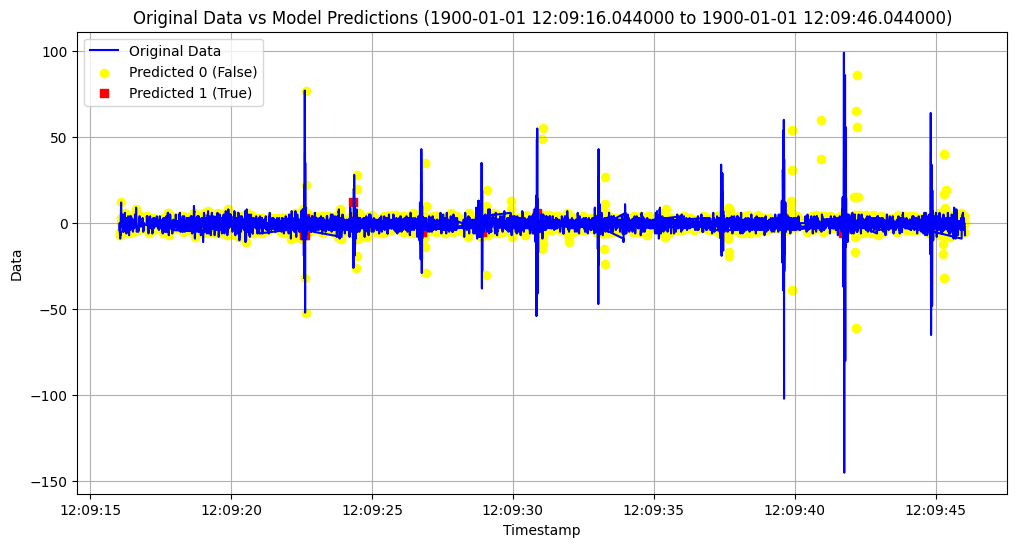

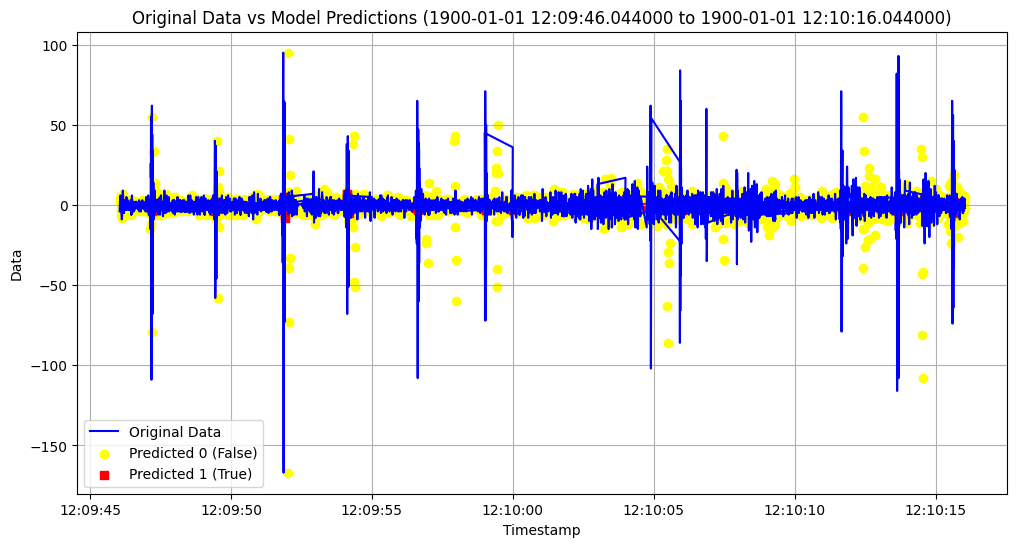

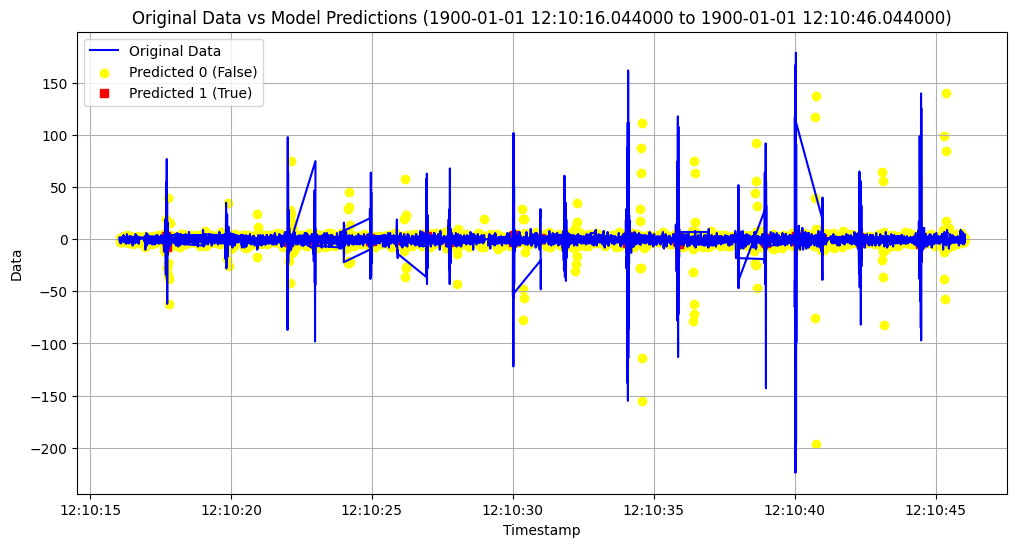

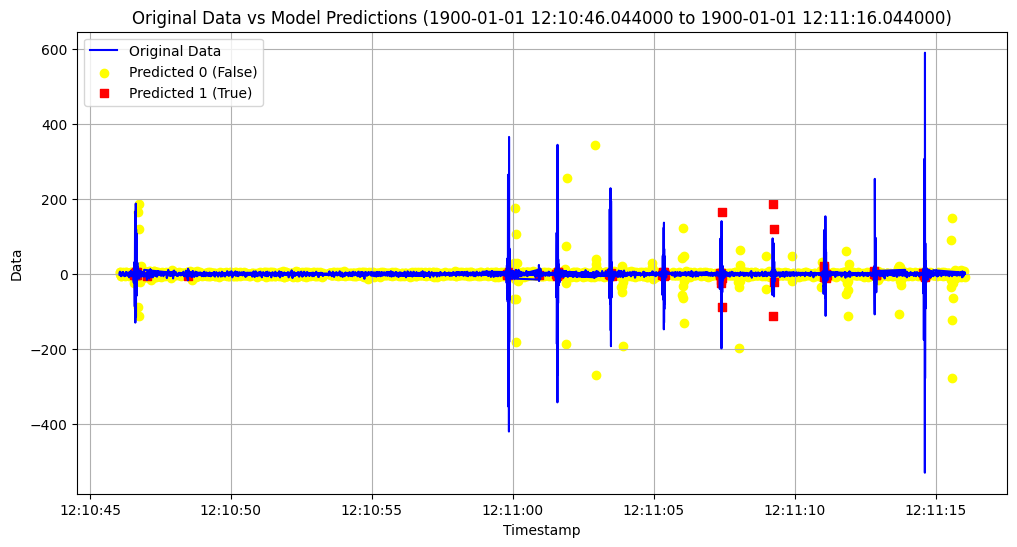

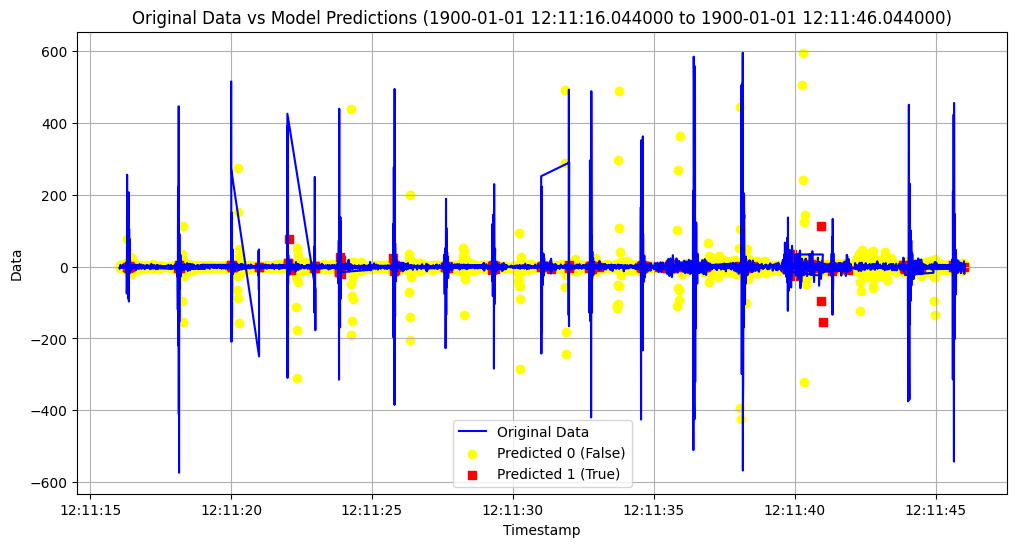

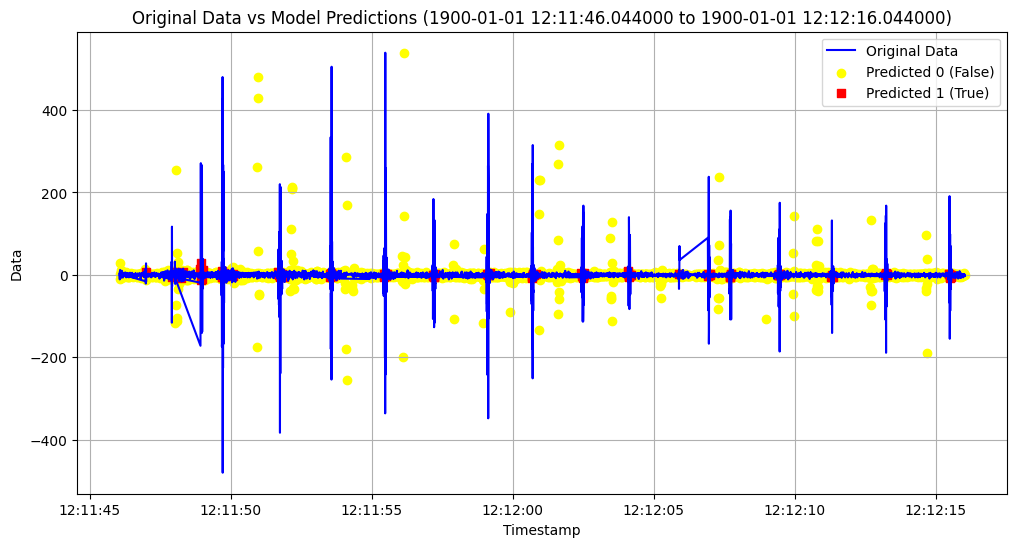

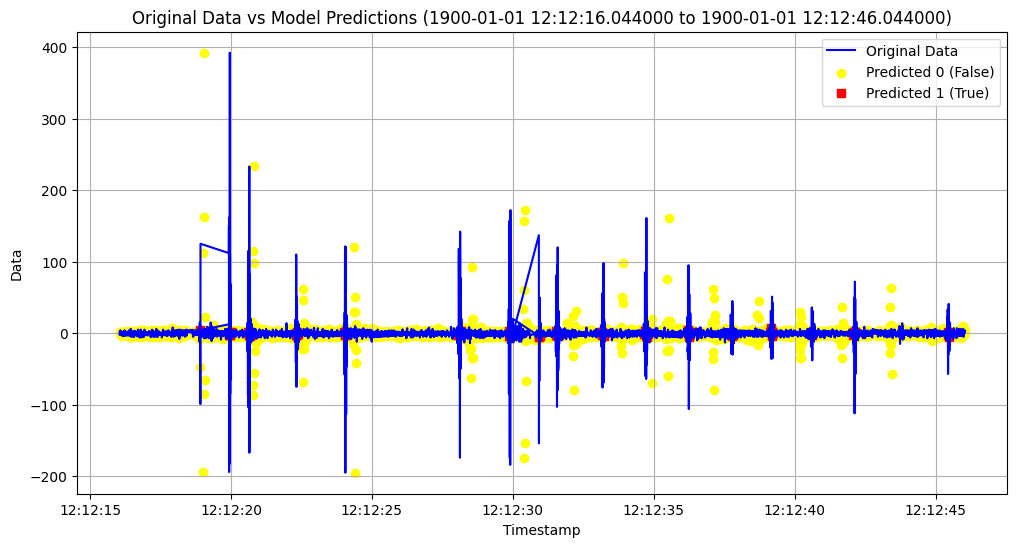

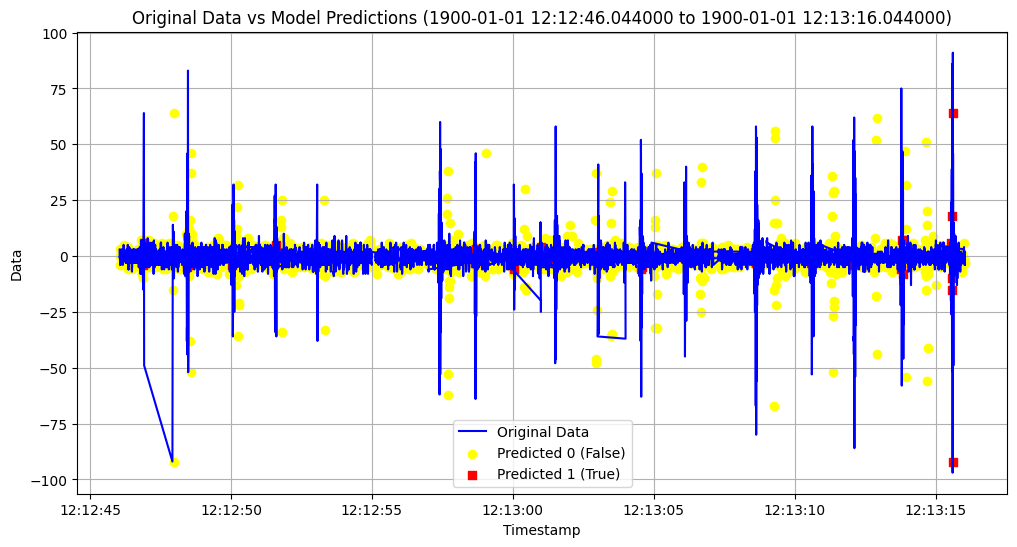

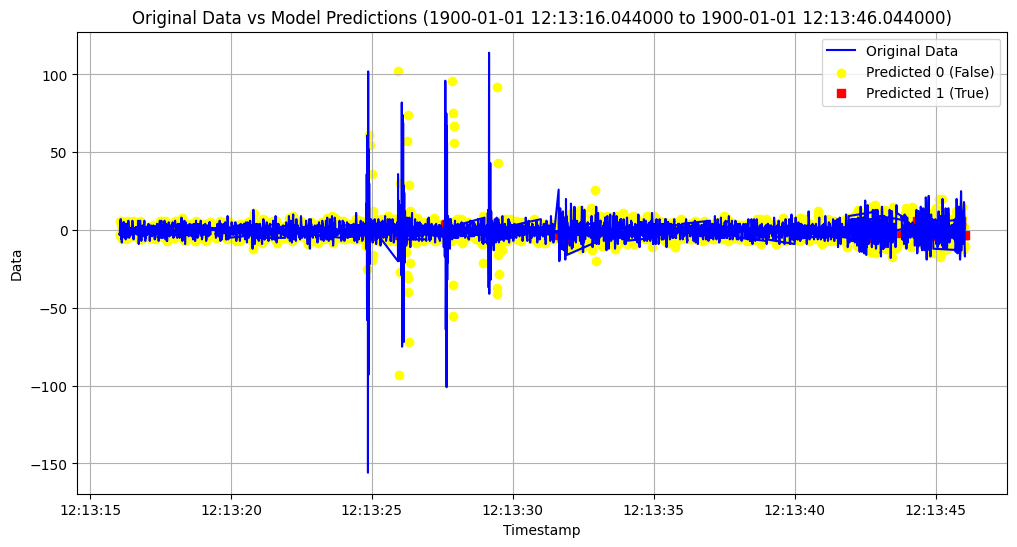

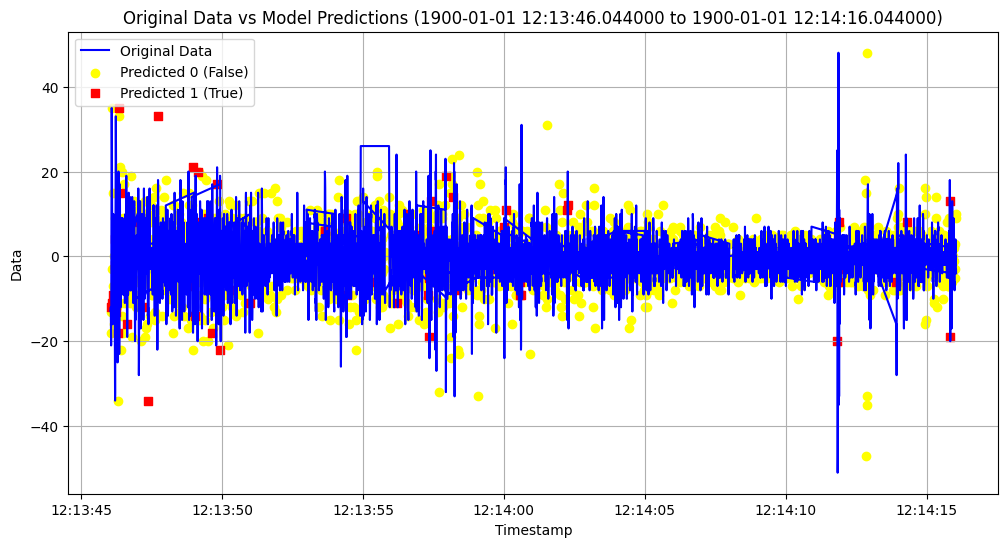

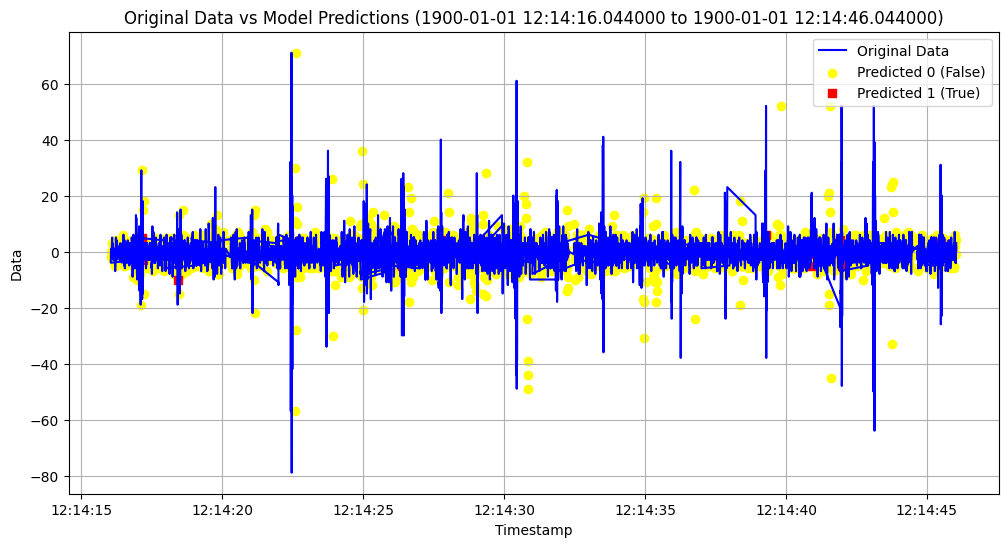

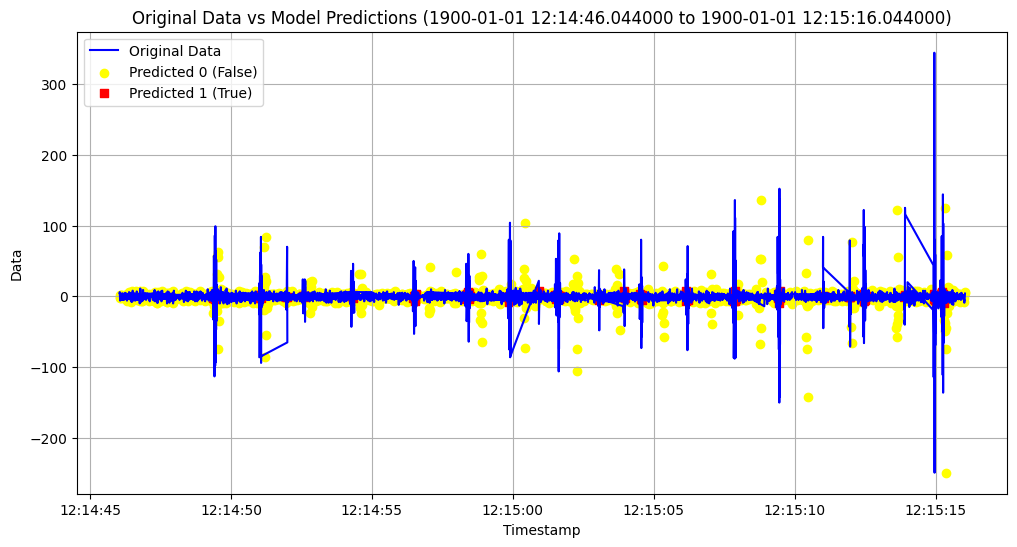

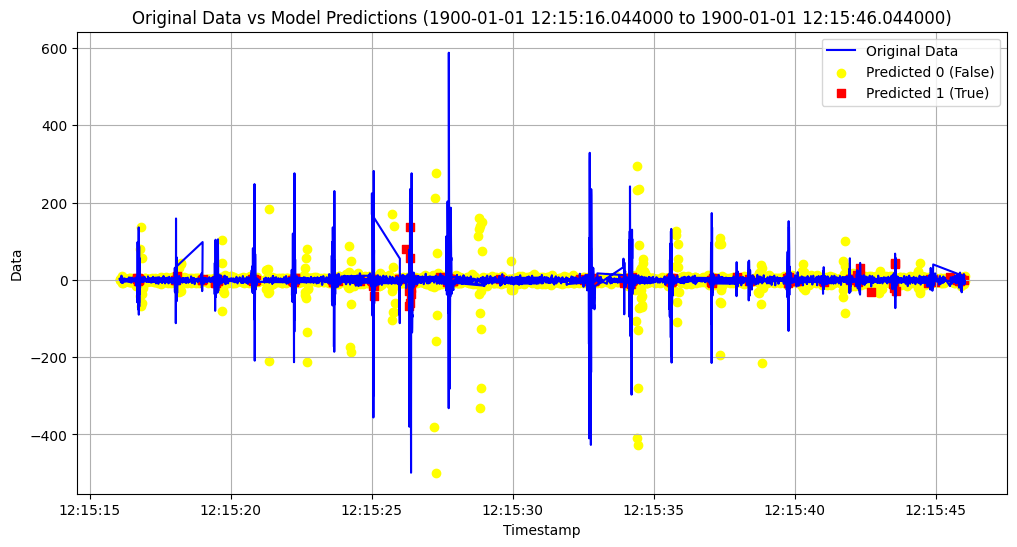

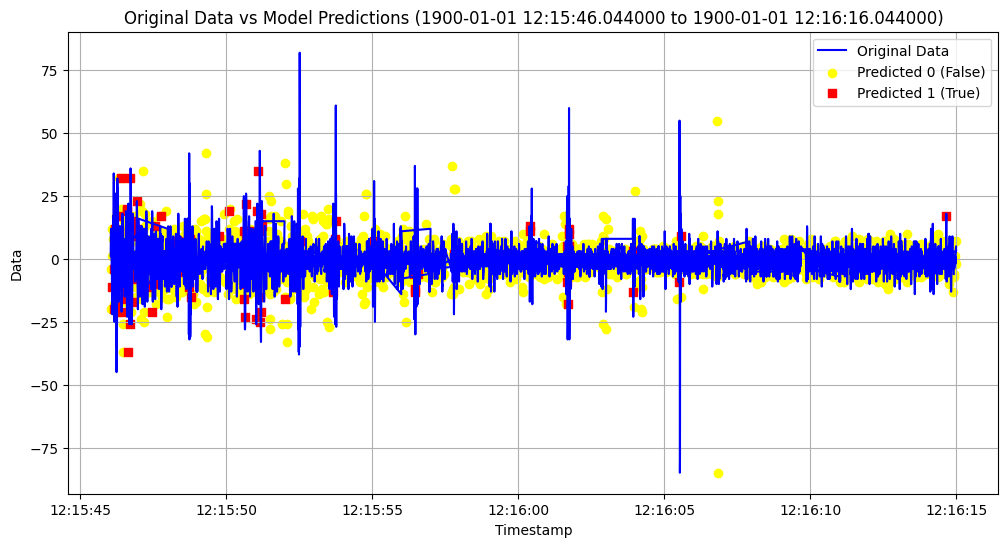

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model = load_model('lstm_only_model.h5')

csv_file_path = '/content/Node B 20m first test.csv'  # Adjust the path as needed
df = pd.read_csv(csv_file_path)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Ensure proper timestamp parsing
timestamps = df['Timestamp']
data = df['Data'].values

sequence_length = 3

def create_sequences_for_inference(data, sequence_length):
    X = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        X.append(data[i:i + sequence_length].reshape(-1, 1))
    return np.array(X)

X_infer = create_sequences_for_inference(df['Data'].values, sequence_length)

predictions = model.predict(X_infer)

predicted_values = np.argmax(predictions, axis=1)

predicted_timestamps = timestamps[sequence_length-1::sequence_length]

def filter_by_time_range(start_time, end_time, timestamps, data, predicted_timestamps, predicted_values):
    mask = (timestamps >= start_time) & (timestamps <= end_time)
    timestamps_filtered = timestamps[mask]
    data_filtered = data[mask]

    mask_predictions = (predicted_timestamps >= start_time) & (predicted_timestamps <= end_time)
    predicted_timestamps_filtered = predicted_timestamps[mask_predictions]
    predicted_values_filtered = predicted_values[mask_predictions]

    return timestamps_filtered, data_filtered, predicted_timestamps_filtered, predicted_values_filtered


current_time = timestamps.min()
end_time = timestamps.max()

while current_time < end_time:
    next_time = current_time + pd.Timedelta(seconds=30)

    timestamps_filtered, data_filtered, predicted_timestamps_filtered, predicted_values_filtered = filter_by_time_range(
        current_time, next_time, timestamps, data, predicted_timestamps, predicted_values
    )

    plt.figure(figsize=(12, 6))

    plt.plot(timestamps_filtered, data_filtered, label='Original Data', color='blue')

    plt.scatter(predicted_timestamps_filtered[predicted_values_filtered == 0],
                data_filtered[sequence_length-1::sequence_length][:len(predicted_values_filtered[predicted_values_filtered == 0])],
                label='Predicted 0 (False)', color='yellow', marker='o')

    plt.scatter(predicted_timestamps_filtered[predicted_values_filtered == 1],
                data_filtered[sequence_length-1::sequence_length][:len(predicted_values_filtered[predicted_values_filtered == 1])],
                label='Predicted 1 (True)', color='red', marker='s')

    plt.xlabel('Timestamp')
    plt.ylabel('Data')
    plt.title(f'Original Data vs Model Predictions ({current_time} to {next_time})')
    plt.legend()
    plt.grid(True)
    plt.show()

    current_time = next_time
